# Graph Convolutional Networks

In [ ]:
!pip -q install torch_geometric

import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00


In [ ]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [ ]:
import torch_geometric

In [ ]:
from torch_geometric.datasets import Amazon

In [ ]:
from torch_geometric.utils import to_dense_adj

In [ ]:
from IPython.display import HTML
from matplotlib import animation
from torch_geometric.utils import to_networkx

## code structures

### common

In [ ]:
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

In [ ]:
class EarlyStopping():
  def __init__(self, min_delta=0.001, tolerance=20):
    self.tolerance = tolerance
    self.min_delta = min_delta
    self.counter = 0
    self.flag = False
    self.min_loss = 1000

  def __call__(self, val_loss):
    if (val_loss - self.min_loss) > self.min_delta:
      self.counter += 1
      print(f'\ncounter = {self.counter}')
      if self.counter >= self.tolerance:
        self.flag = True
    self.min_loss = val_loss if val_loss < self.min_loss else self.min_loss

### gcn

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 2 * num_features, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * num_features, num_features, cached=True) # cached only for transductive learning
        self.fc = torch.nn.Linear(num_features, num_classes)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.fc(x)

In [ ]:
def train_one_epoch_gcc(model, optimizer, loss_func, x, y, train_pos_edge_index):
    model.train()
    optimizer.zero_grad()
    y_pred = model.forward(x, train_pos_edge_index)
    loss = loss_func.forward(y_pred, y)
    loss.backward()
    optimizer.step()
    _, y_pred = torch.max(y_pred, 1)
    return loss.item(), accuracy(y_pred, y)

def val_one_epoch_gcc(model, loss_func, x, y, val_pos_edge_index):
    model.eval()
    y_pred = model.forward(x, val_pos_edge_index)
    loss = loss_func.forward(y_pred, y)
    _, y_pred = torch.max(y_pred, 1)
    return loss.item(), accuracy(y_pred, y)

In [ ]:
def test(model, x, y, test_pos_edge_index, classes):
    model.eval()
    conf_matr = torch.zeros(len(classes), len(classes))
    y_pred = model.forward(x, test_pos_edge_index)
    _, preds = torch.max(y_pred, 1)
    test_hits = torch.sum(preds.view(-1) == y.view(-1))
    total = torch.numel(preds.view(-1))
    for t,p in zip(y.view(-1), preds.view(-1)):
        conf_matr[t.long(), p.long()] += 1
    return conf_matr, test_hits/total

def test_model_gcc(model, data, classes):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    x = data.x.to(device)
    y = data.y.to(device)
    test_pos_edge_index = data.test_pos_edge_index.to(device)
    return test(model, x, y, test_pos_edge_index, classes)

In [ ]:
def train_n_epoch_gcc(model, optimizer, loss_func, data, max_epoch, min_delta, tolerance, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = data.x.to(device)
    y = data.y.to(device)
    model.to(device)
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_pos_edge_index = data.train_pos_edge_index.to(device)
    val_pos_edge_index = data.val_pos_edge_index.to(device)
    early_stopping = EarlyStopping(min_delta=min_delta, tolerance=tolerance)

    for i in range(max_epoch):
        train_metrics = train_one_epoch_gcc(model, optimizer, loss_func, x, y, train_pos_edge_index)
        train_losses.append(train_metrics[0])
        train_accs.append(train_metrics[1])

        with torch.no_grad():
            val_metrics = val_one_epoch_gcc(model, loss_func, x, y, val_pos_edge_index)
            val_losses.append(val_metrics[0])
            val_accs.append(val_metrics[1])

        if verbose and i%10==0:
            print(f'Epoch {i:>3} | train loss: {train_metrics[0]:.2f} | train acc: {train_metrics[1]*100:.2f}% | val loss: {val_metrics[0]:.2f} | val acc: {val_metrics[1]*100:.2f}%')

        early_stopping(val_metrics[0])
        if early_stopping.flag:
            print(f'\nearly stop at epoch №{i}')
            break
    return train_losses, train_accs, val_losses, val_accs

### normal

In [ ]:
class LinearModel(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(LinearModel, self).__init__()
        self.fc1 = torch.nn.Linear(num_features, num_features//2)
        self.fc2 = torch.nn.Linear(num_features//2, num_features//4)
        self.fc3 = torch.nn.Linear(num_features//4, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
def train_one_epoch(model, train_dataloader, loss_func, optimizer, device):
  model.train()
  epoch_loss = []
  for (local_batch, local_label) in train_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    optimizer.zero_grad()
    y_pred = model.forward(local_batch)
    curr_loss = criterion.forward(y_pred, local_label)
    curr_loss.backward()
    optimizer.step()
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

#use with torch.no_grad()
def val_one_epoch(model, val_dataloader, loss_func, device):
  model.eval()
  epoch_loss = []
  for (local_batch, local_label) in val_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_batch)
    curr_loss = criterion.forward(y_pred, local_label)
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

def test_model(model, test_dataloader, device, classes):
  model.eval()
  test_hits = 0
  total = 0
  confusion_matrix = torch.zeros(len(classes), len(classes))
  for (local_batch, local_label) in test_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_batch)
    _, preds = torch.max(y_pred, 1)
    test_hits += torch.sum(preds.view(-1) == local_label.view(-1))
    total += torch.numel(preds.view(-1))
    for t, p in zip(local_label.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix, test_hits, total

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self):
        dataset = Amazon(root='/', name='Computers', transform=torch_geometric.transforms.NormalizeFeatures())
        self.num_features = dataset.num_features
        self.num_classes = dataset.num_classes
        dataset = dataset[0]
        self.X = dataset['x']
        self.y = dataset['y']

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## graph params

In [ ]:
# Import dataset from PyTorch Geometric
dataset = Amazon(root='/', name='Computers', transform=torch_geometric.transforms.NormalizeFeatures())

# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


AmazonComputers()
------------
Number of graphs: 1
Number of features: 767
Number of classes: 10


Done!


In [ ]:
# Print first element
print(f'Graph: {dataset.data}')

Graph: Data(x=[13752, 767], edge_index=[2, 491722], y=[13752])


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [ ]:
dataset.data.edge_index

tensor([[    0,     0,     0,  ..., 13751, 13751, 13751],
        [  507,  6551,  8210,  ..., 12751, 13019, 13121]])

In [ ]:
dataset.data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 1., 1., 0.]])

In [ ]:
dataset.data.y

tensor([4, 4, 8,  ..., 8, 4, 0])

## GCN model

In [ ]:
epochs = 1000
lr = 1e-3
dataset = Amazon(root='/', name='Computers', transform=torch_geometric.transforms.NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
model = GCN(num_features, num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
)
min_delta = 5e-3
tolerance = 10

In [ ]:
data = dataset[0]
data = torch_geometric.utils.train_test_split_edges(data, test_ratio=0.2, val_ratio=0.1)
data

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[13752, 767], y=[13752], val_pos_edge_index=[2, 24586], test_pos_edge_index=[2, 49172], train_pos_edge_index=[2, 344206], train_neg_adj_mask=[13752, 13752], val_neg_edge_index=[2, 24586], test_neg_edge_index=[2, 49172])

In [ ]:
data['train_neg_adj_mask'] = data['val_neg_edge_index'] = data['test_neg_edge_index'] = None
data

Data(x=[13752, 767], y=[13752], val_pos_edge_index=[2, 24586], test_pos_edge_index=[2, 49172], train_pos_edge_index=[2, 344206])

In [ ]:
train_losses, train_accs, val_losses, val_accs = train_n_epoch_gcc(model, optimizer, criterion, data, epochs, min_delta, tolerance)

Epoch   0 | train loss: 2.29 | train acc: 15.68% | val loss: 2.28 | val acc: 16.27%
Epoch  10 | train loss: 1.95 | train acc: 37.51% | val loss: 1.95 | val acc: 37.51%

counter = 1

counter = 2

counter = 3

counter = 4

counter = 5
Epoch  20 | train loss: 1.92 | train acc: 37.51% | val loss: 1.92 | val acc: 37.51%
Epoch  30 | train loss: 1.90 | train acc: 37.51% | val loss: 1.89 | val acc: 37.51%
Epoch  40 | train loss: 1.84 | train acc: 37.51% | val loss: 1.83 | val acc: 37.51%
Epoch  50 | train loss: 1.73 | train acc: 37.51% | val loss: 1.72 | val acc: 37.51%
Epoch  60 | train loss: 1.56 | train acc: 39.97% | val loss: 1.55 | val acc: 40.86%
Epoch  70 | train loss: 1.41 | train acc: 50.41% | val loss: 1.40 | val acc: 51.14%
Epoch  80 | train loss: 1.27 | train acc: 54.74% | val loss: 1.25 | val acc: 56.23%
Epoch  90 | train loss: 1.11 | train acc: 67.02% | val loss: 1.09 | val acc: 67.46%
Epoch 100 | train loss: 0.93 | train acc: 69.82% | val loss: 0.92 | val acc: 69.68%
Epoch 110 |

<Axes: >

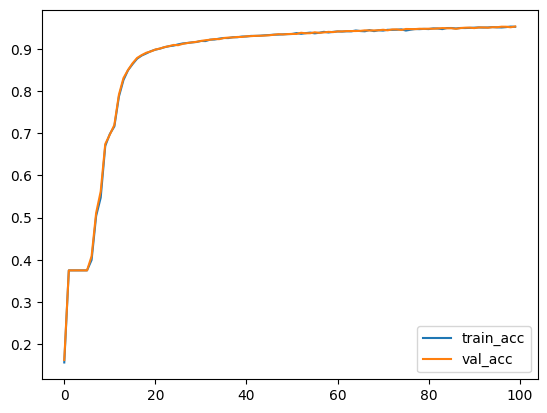

In [ ]:
df = pd.DataFrame({'train_acc': [x.item() for x in train_accs[::10]], 'val_acc': [x.item() for x in val_accs[::10]]})
df.plot(kind='line')

<Axes: >

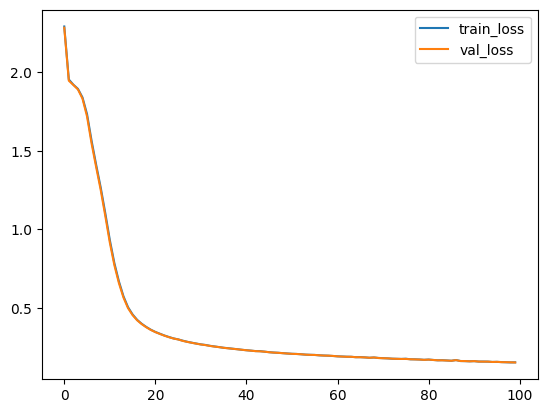

In [ ]:
df = pd.DataFrame({'train_loss': [np.mean(x) for x in train_losses[::10]], 'val_loss': [np.mean(x) for x in val_losses[::10]]})
df.plot(kind='line')

In [ ]:
conf_matr, acc = test_model_gcc(model, data, [i for i in range(dataset.num_classes)])

<Axes: >

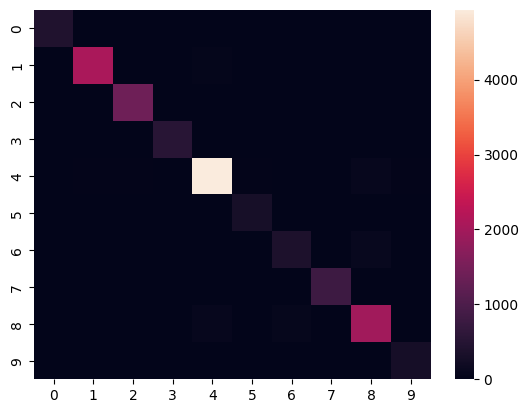

In [ ]:
from seaborn import heatmap
heatmap(conf_matr)

In [ ]:
print(f'test acc = {round(acc.item()*100, 2)}%')

test acc = 95.31%


## Linear model

In [ ]:
dataset = Dataset()
BATCH_SIZE = 100
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None
min_delta = 5e-3
tolerance = 10

In [ ]:
trainSize = int(0.8*len(dataset))
valSize = int(0.1*len(dataset))
testSize = len(dataset) - trainSize - valSize
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainSize, valSize, testSize])

In [ ]:
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

In [ ]:
num_features, num_classes = dataset.num_features, dataset.num_classes

In [ ]:
model = LinearModel(num_features, num_classes).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 369408


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=min_delta, tolerance=tolerance)

In [ ]:
train_loss = []
val_loss = []
for epoch in range(EPOCH):
    print(f'epoch = {epoch}, ', end="")
    epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
    train_loss.append(epoch_train_loss)

    with torch.no_grad():
        epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
        val_loss.append(epoch_val_loss)

    early_stopping(epoch_val_loss)
    if early_stopping.flag:
        print(f'early stop at epoch №{epoch}')
        break
torch.cuda.empty_cache() if device == 'cuda' else None

epoch = 0, epoch = 1, epoch = 2, epoch = 3, epoch = 4, epoch = 5, epoch = 6, 
counter = 1
epoch = 7, epoch = 8, 
counter = 2
epoch = 9, 
counter = 3
epoch = 10, epoch = 11, 
counter = 4
epoch = 12, 
counter = 5
epoch = 13, 
counter = 6
epoch = 14, 
counter = 7
epoch = 15, 
counter = 8
epoch = 16, 
counter = 9
epoch = 17, 
counter = 10
early stop at epoch №17


<Axes: >

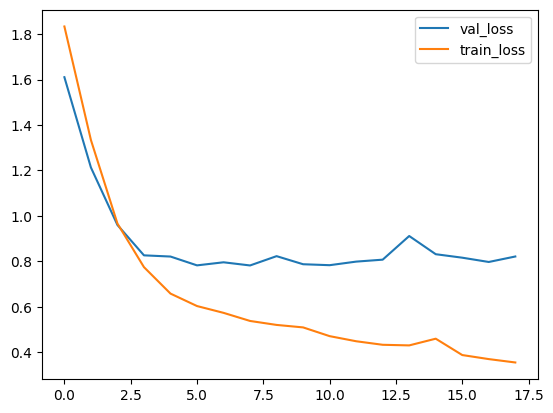

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, [i for i in range(dataset.num_classes)])
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 79.22%


<Axes: >

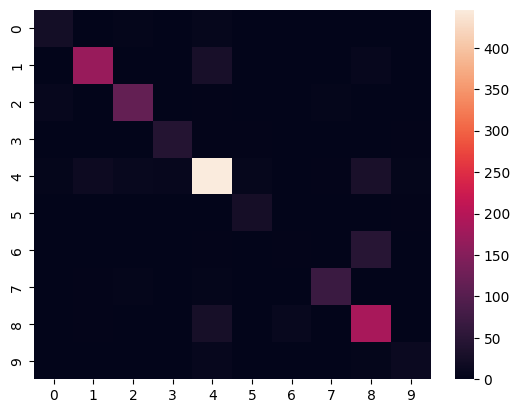

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])